# Spaceship Titanic Passenger Data

This dataset contains personal records of the passengers aboard the Spaceship Titanic. The main task is to predict whether a passenger was transported to another dimension based on their personal and transactional information.

## Dataset Files

[Spaceship Titanic Passenger Data](https://www.kaggle.com/competitions/spaceship-titanic/data)

### 1. `train.csv`
Contains personal records for about (~8700) of the passengers.

#### Columns:

- `PassengerId`: A unique Id for each passenger, formatted as `gggg_pp`. `gggg` indicates a group the passenger is traveling with, and `pp` is their number within the group. People in a group could be family members or others.
- `HomePlanet`: The planet the passenger departed from, typically their planet of permanent residence.
- `CryoSleep`: Indicates if the passenger chose to be in suspended animation for the voyage. Passengers in cryosleep stay in their cabins.
- `Cabin`: The cabin number, formatted as `deck/num/side`. `side` can be either 'P' for Port or 'S' for Starboard.
- `Destination`: The planet the passenger will debark to.
- `Age`: The age of the passenger.
- `VIP`: Indicates if the passenger paid for special VIP service during the voyage.
- `RoomService`, `FoodCourt`, `ShoppingMall`, `Spa`, `VRDeck`: Amount billed by the passenger at each of Spaceship Titanic's luxury amenities.
- `Name`: First and last names of the passenger.
- `Transported`: Whether the passenger was transported to another dimension. This is the target variable.

In [205]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os
import pandas as pd
import seaborn as sns

#
pd.set_option("display.max_rows", 999)

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

plt.rcParams["axes.labelsize"] = 14
plt.rcParams["xtick.labelsize"] = 12
plt.rcParams["ytick.labelsize"] = 12

import scipy.stats as stats

# layout the code line
import jupyter_black

jupyter_black.load()

# Ignore useless warnings (see SciPy issue #5998)
import warnings

warnings.filterwarnings(action="ignore", message="^internal gelsd")

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc

# Step 1: Data cleaning

In [206]:
PATH = r"/Users/fulin/Documents/GitHub/Python_Project_Group_09/spaceship-titanic/data/"
os.chdir(PATH)

In [207]:
df_init = pd.read_csv("train.csv")

In [208]:
df = df_init.copy()

In [209]:
print(f"Shape of dataframe is {df.shape}")
display(df.info())

Shape of dataframe is (8693, 14)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


None

In [210]:
df.drop(columns=["Name"], inplace=True)

In [211]:
df["Cabin"].isna().sum()

199

## Feature engineering

In [212]:
df["Deck"] = df["Cabin"].apply(
    lambda x: x.split("/")[0] if isinstance(x, str) and "/" in x else np.nan
)
df["Num"] = df["Cabin"].apply(
    lambda x: x.split("/")[1] if isinstance(x, str) and "/" in x else np.nan
)
df["Side"] = df["Cabin"].apply(
    lambda x: x.split("/")[2] if isinstance(x, str) and "/" in x else np.nan
)

In [213]:
df["familyId"] = df["PassengerId"].str.extract(r"(\d+)_")
df["familySize"] = df.groupby("familyId")["PassengerId"].transform("count")

In [214]:
df.drop(columns=["PassengerId", "Cabin", "familyId"], axis=1, inplace=True)

In [215]:
df.head(5)

HomePlanet CryoSleep  Destination   Age    VIP  RoomService  FoodCourt  \
0     Europa     False  TRAPPIST-1e  39.0  False          0.0        0.0   
1      Earth     False  TRAPPIST-1e  24.0  False        109.0        9.0   
2     Europa     False  TRAPPIST-1e  58.0   True         43.0     3576.0   
3     Europa     False  TRAPPIST-1e  33.0  False          0.0     1283.0   
4      Earth     False  TRAPPIST-1e  16.0  False        303.0       70.0   

   ShoppingMall     Spa  VRDeck  Transported Deck Num Side  familySize  
0           0.0     0.0     0.0        False    B   0    P           1  
1          25.0   549.0    44.0         True    F   0    S           1  
2           0.0  6715.0    49.0        False    A   0    S           2  
3         371.0  3329.0   193.0        False    A   0    S           2  
4         151.0   565.0     2.0         True    F   1    S           1

# Step 2: Data explorision

Text(0.5, 1.0, 'Transported Feature Distribution')

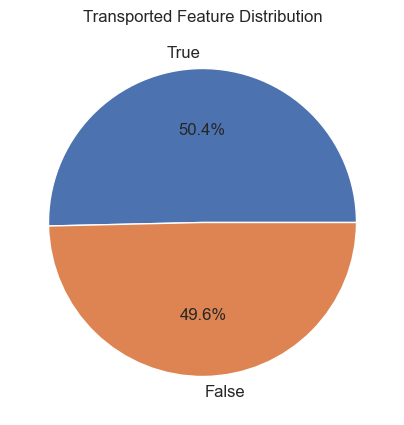

In [216]:
plt.figure(figsize=(5, 5))
plt.pie(
    df["Transported"].value_counts(),
    labels=df["Transported"].value_counts().keys(),
    autopct="%1.1f%%",
)
plt.title("Transported Feature Distribution")

<Axes: >

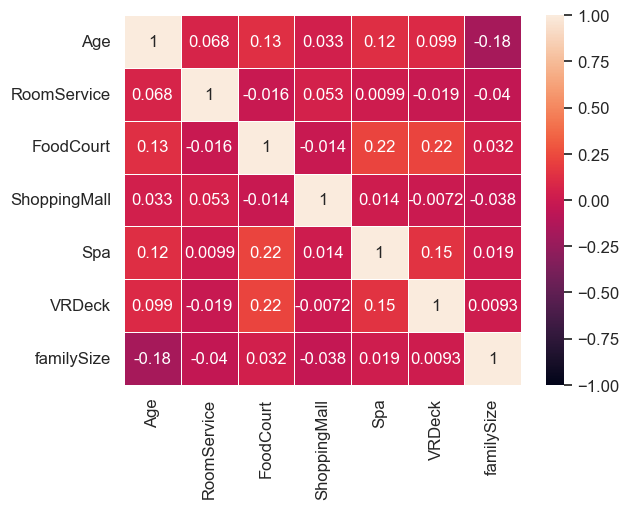

In [217]:
sns.heatmap(quant_col.corr(), annot=True, linewidths=0.5, vmin=-1, vmax=1)

In [218]:
def quant_cat_analysis(data, quant_var, cat_var):
    """
    A fonction to discover the link from between a quantitive variable and a categorical variable
    By using ANOVA analysis
    """

    anova_table = pd.DataFrame(
        columns=["Source", "DF", "Sum of Squares", "Mean Square", "F", "PR(>F)"]
    )

    groups = data.groupby(cat_var)
    for group_name, group_data in groups:
        group_values = [group_data[quant_var].values for _, group_data in groups]
        f_statistic, p_value = stats.f_oneway(*group_values)
        df_between = len(groups) - 1
        df_within = len(data) - len(groups)
        ss_between = (group_data[quant_var].mean() - data[quant_var].mean()) ** 2 * len(
            group_data
        )
        ss_within = ((group_data[quant_var] - group_data[quant_var].mean()) ** 2).sum()
        ms_between = ss_between / df_between
        ms_within = ss_within / df_within
        anova_table = anova_table.append(
            {
                "Source": group_name,
                "DF": df_between,
                "Sum of Squares": ss_between,
                "Mean Square": ms_between,
                "F": f_statistic,
                "PR(>F)": p_value,
            },
            ignore_index=True,
        )

    print("ANOVA table:")
    display(anova_table)

    p_values = anova_table["PR(>F)"]
    significant_diff = p_values < 0.05
    # print(f"Significance({quant_var} and {cat_var}): {significant_diff}")
    print(f"Significance({quant_var} and {cat_var}):\n")
    display(significant_diff)

    sns.set(style="whitegrid")
    plt.figure(figsize=(2, 5))
    sns.boxplot(x=cat_var, y=quant_var, data=data, palette="Set3")

    plt.title(f"Grouped Boxplots for {quant_var} by {cat_var}")

    plt.show()

In [219]:
def cat_cat_analysis(data, var1, var2):
    """
    The fonction to check the relationship between two categorical variables
    By using the chi-squre and providing the carmens'v
    """

    # Generate the contingency table
    contingency_table = pd.crosstab(data[var1], data[var2])

    # Check the significance of their relationship with the chi-square test
    chi2, p, dof, expected_freq = stats.chi2_contingency(contingency_table)

    # Calculate Cramer's V
    n = contingency_table.values.sum()
    k = contingency_table.shape[0]
    r = contingency_table.shape[1]
    V = np.sqrt(chi2 / (n * min(k - 1, r - 1)))
    print("Cramer's V:", V)

    observed_table = contingency_table
    expected_table = expected_freq
    expected_table = pd.DataFrame(
        expected_freq, index=contingency_table.index, columns=contingency_table.columns
    )  # Convert expected_freq to a DataFrame

    n = contingency_table.values.sum()

    residual_table = (observed_table - expected_table) / np.sqrt(expected_table)

    print("Observed Table:")
    display(observed_table)
    print("\nExpected Table:")
    display(expected_table)
    print("\nResidual Table:")
    display(residual_table)

    print(f"\nChi-Squared Statistic: {chi2}, p-value: {p}, Degree of freedom : {dof}")
    significant_diff = p < 0.05
    print(f"\nSignificance({var1} and {var2}): {significant_diff}")

    # Plot side-by-side bar charts
    contingency_table.plot(kind="bar", stacked=True)
    plt.title(f"Side-by-Side Bar Chart for {var1} vs {var2}")
    plt.xlabel(var1)
    plt.ylabel("Frequency")
    plt.show()

    # Plot stacked bar charts
    contingency_table.T.plot(kind="bar", stacked=True)
    plt.title(f"Stacked Bar Chart for {var2} vs {var1}")
    plt.xlabel(var2)
    plt.ylabel("Frequency")
    plt.show()

ANOVA table:


/var/folders/cr/dlw4zhlj7ld9t1grnb2q9hvw0000gn/T/ipykernel_7204/973082815.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  anova_table = anova_table.append(
/var/folders/cr/dlw4zhlj7ld9t1grnb2q9hvw0000gn/T/ipykernel_7204/973082815.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  anova_table = anova_table.append(
/var/folders/cr/dlw4zhlj7ld9t1grnb2q9hvw0000gn/T/ipykernel_7204/973082815.py:23: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  anova_table = anova_table.append(


Source DF  Sum of Squares  Mean Square          F        PR(>F)
0  False  1       76.191188    76.191188  59.768286  1.186047e-14
1   True  1       75.094787    75.094787  59.768286  1.186047e-14

Significance(familySize and Transported):



0    True
1    True
Name: PR(>F), dtype: bool

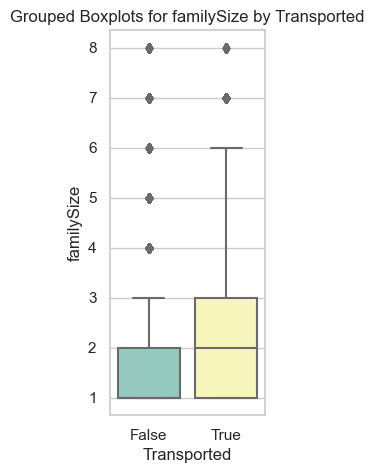

In [220]:
quant_cat_analysis(df, "familySize", "Transported")

Cramer's V: 0.19560087242990837
Observed Table:


Transported  False  True 
HomePlanet               
Earth         2651   1951
Europa         727   1404
Mars           839    920


Expected Table:


Transported        False        True 
HomePlanet                           
Earth        2285.284268  2316.715732
Europa       1058.222680  1072.777320
Mars          873.493052   885.506948


Residual Table:


Transported      False      True 
HomePlanet                       
Earth         7.650213  -7.598140
Europa      -10.181963  10.112657
Mars         -1.167083   1.159139


Chi-Squared Statistic: 324.9013834000382, p-value: 2.809059985251311e-71, Degree of freedom : 2

Significance(HomePlanet and Transported): True


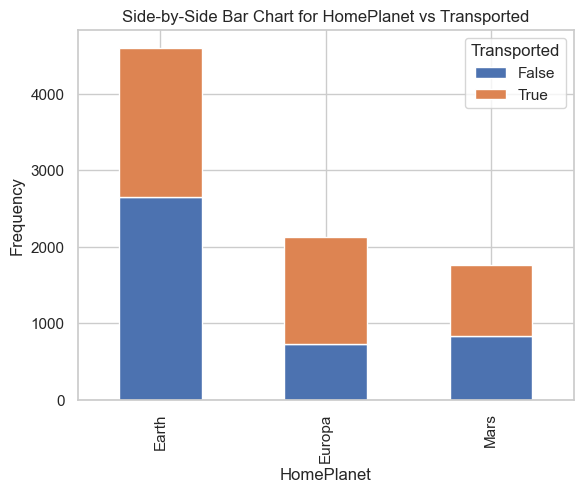

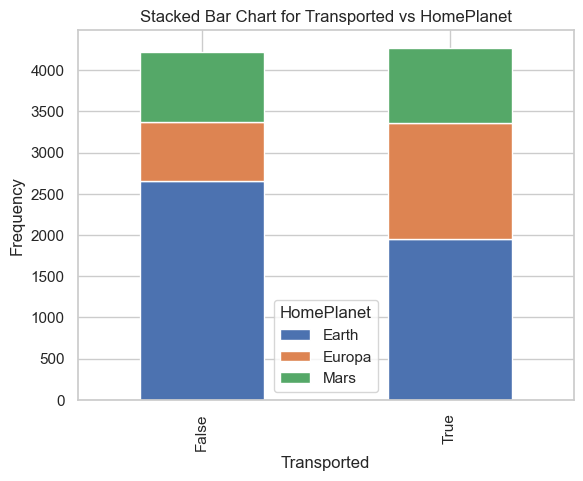

In [221]:
cat_cat_analysis(df, "HomePlanet", "Transported")

Cramer's V: 0.4683988058935883
Observed Table:


Transported  False  True 
CryoSleep                
False         3650   1789
True           554   2483


Expected Table:


Transported        False        True 
CryoSleep                            
False        2697.682397  2741.317603
True         1506.317603  1530.682397


Residual Table:


Transported      False      True 
CryoSleep                        
False        18.335232 -18.188720
True        -24.537117  24.341048


Chi-Squared Statistic: 1859.6127129888841, p-value: 0.0, Degree of freedom : 1

Significance(CryoSleep and Transported): True


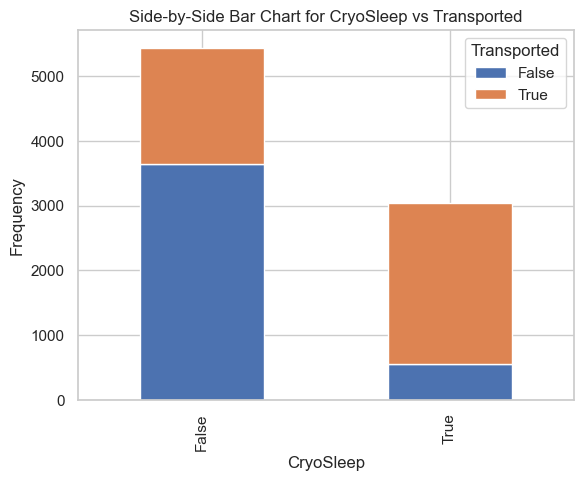

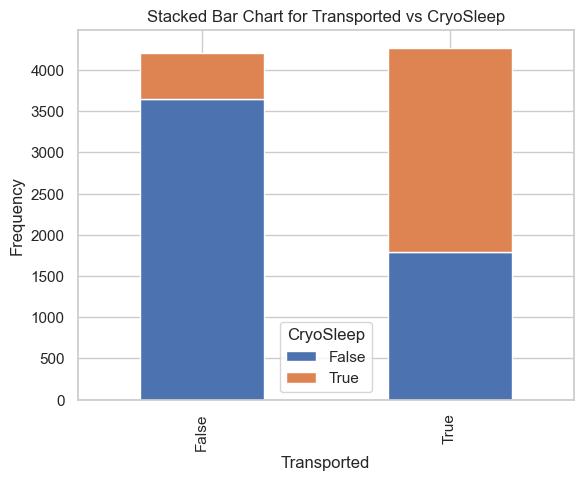

In [222]:
cat_cat_analysis(df, "CryoSleep", "Transported")

Cramer's V: 0.11180584580691638
Observed Table:


Transported    False  True 
Destination                
55 Cancri e      702   1098
PSO J318.5-22    395    401
TRAPPIST-1e     3128   2787


Expected Table:


Transported          False        True 
Destination                            
55 Cancri e     893.549524   906.450476
PSO J318.5-22   395.147456   400.852544
TRAPPIST-1e    2936.303020  2978.696980


Residual Table:


Transported       False     True 
Destination                      
55 Cancri e   -6.407989  6.362225
PSO J318.5-22 -0.007418  0.007365
TRAPPIST-1e    3.537650 -3.512385


Chi-Squared Statistic: 106.39215684982227, p-value: 7.892901466137099e-24, Degree of freedom : 2

Significance(Destination and Transported): True


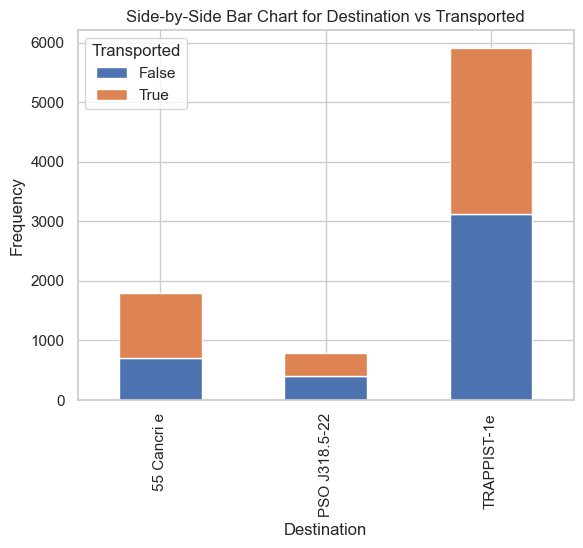

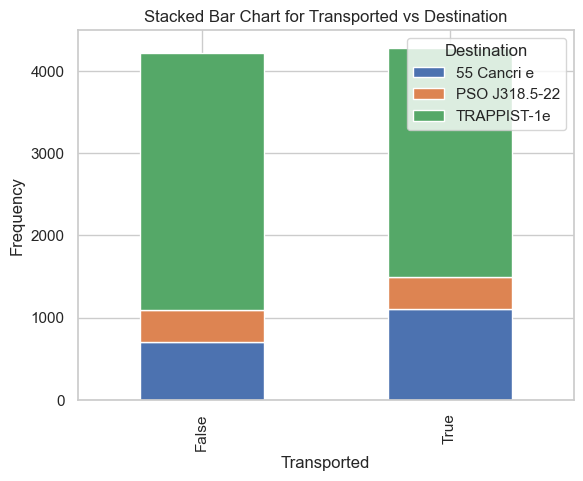

In [223]:
cat_cat_analysis(df, "Destination", "Transported")

Cramer's V: 0.036871183678923294
Observed Table:


Transported  False  True 
VIP                      
False         4093   4198
True           123     76


Expected Table:


Transported        False        True 
VIP                                  
False        4117.179741  4173.820259
True           98.820259   100.179741


Residual Table:


Transported     False     True 
VIP                            
False       -0.376835  0.374270
True         2.432364 -2.415804


Chi-Squared Statistic: 11.542020738162797, p-value: 0.0006804064556968345, Degree of freedom : 1

Significance(VIP and Transported): True


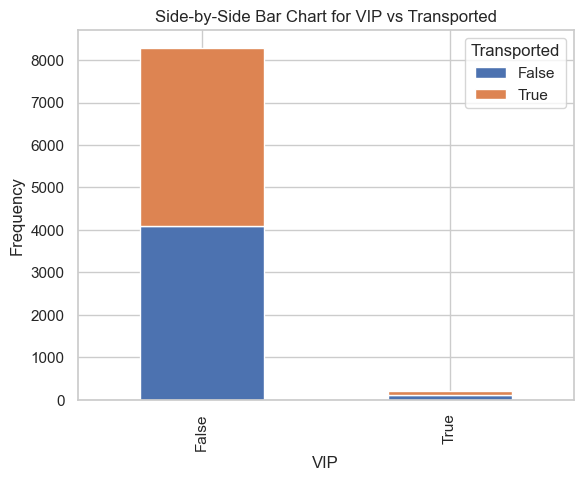

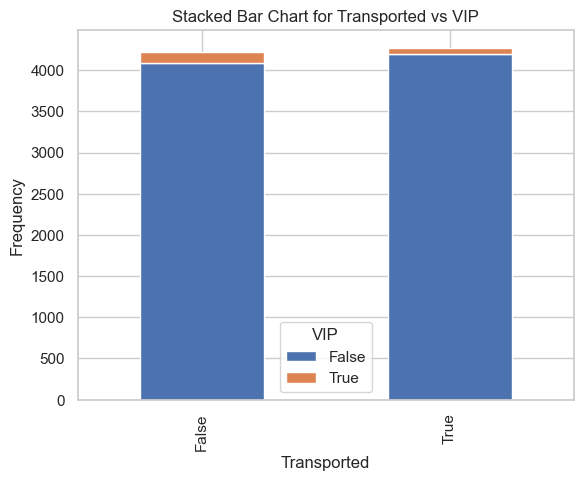

In [224]:
cat_cat_analysis(df, "VIP", "Transported")

Cramer's V: 0.214904943695003
Observed Table:


Transported  False  True 
Deck                     
A              129    127
B              207    572
C              239    508
D              271    207
E              563    313
F             1565   1229
G             1238   1321
T                4      1


Expected Table:


Transported        False        True 
Deck                                 
A             127.065693   128.934307
B             386.656934   392.343066
C             370.773723   376.226277
D             237.255474   240.744526
E             434.802920   441.197080
F            1386.802920  1407.197080
G            1270.160584  1288.839416
T               2.481752     2.518248


Residual Table:


Transported     False     True 
Deck                           
A            0.171598 -0.170350
B           -9.136526  9.070077
C           -6.843438  6.793667
D            2.190762 -2.174829
E            6.147972 -6.103259
F            4.785124 -4.750323
G           -0.902391  0.895828
T            0.963748 -0.956739


Chi-Squared Statistic: 392.2880411997481, p-value: 1.0743307258871414e-80, Degree of freedom : 7

Significance(Deck and Transported): True


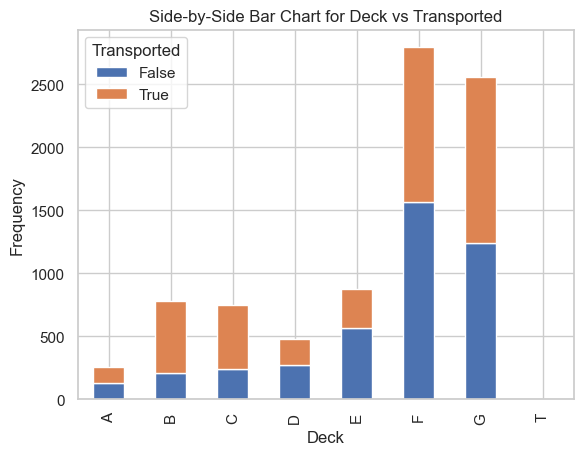

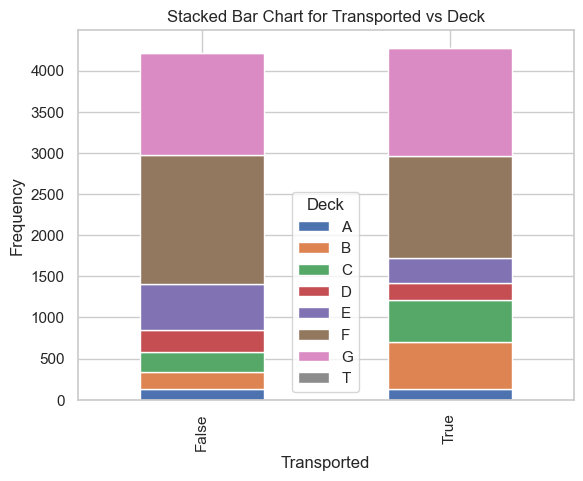

In [225]:
cat_cat_analysis(df, "Deck", "Transported")

Cramer's V: 0.48480288010474376
Observed Table:


Transported  False  True 
Num                      
0               12      6
1                5     10
10               6      6
100              5      7
1000             3      3
...            ...    ...
995              1      2
996              0      1
997              2      0
998              3      1
999              1      5

[1817 rows x 2 columns]


Expected Table:


Transported     False     True 
Num                            
0            8.934307  9.065693
1            7.445255  7.554745
10           5.956204  6.043796
100          5.956204  6.043796
1000         2.978102  3.021898
...               ...       ...
995          1.489051  1.510949
996          0.496350  0.503650
997          0.992701  1.007299
998          1.985401  2.014599
999          2.978102  3.021898

[1817 rows x 2 columns]


Residual Table:


Transported     False     True 
Num                            
0            1.025648 -1.018189
1           -0.896158  0.889640
10           0.017945 -0.017815
100         -0.391801  0.388952
1000         0.012689 -0.012597
...               ...       ...
995         -0.400774  0.397859
996         -0.704521  0.699398
997          1.010996 -1.003643
998          0.720062 -0.714825
999         -1.146249  1.137912

[1817 rows x 2 columns]


Chi-Squared Statistic: 1996.3773737464164, p-value: 0.0018055974346714817, Degree of freedom : 1816

Significance(Num and Transported): True


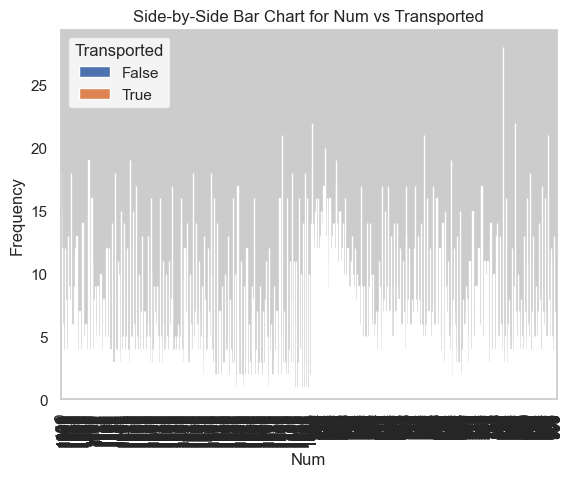

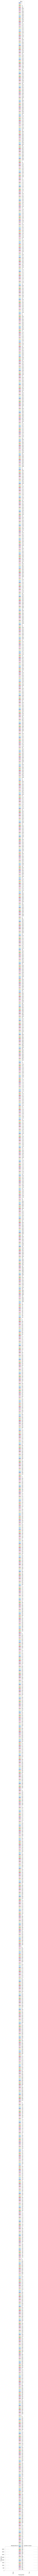

In [226]:
cat_cat_analysis(df, "Num", "Transported")

Cramer's V: 0.10353965983288271
Observed Table:


Transported  False  True 
Side                     
P             2308   1898
S             1908   2380


Expected Table:


Transported        False        True 
Side                                 
P            2087.649635  2118.350365
S            2128.350365  2159.649635


Residual Table:


Transported     False     True 
Side                           
P            4.822641 -4.787567
S           -4.776307  4.741570


Chi-Squared Statistic: 91.0595970786772, p-value: 1.3940936254458288e-21, Degree of freedom : 1

Significance(Side and Transported): True


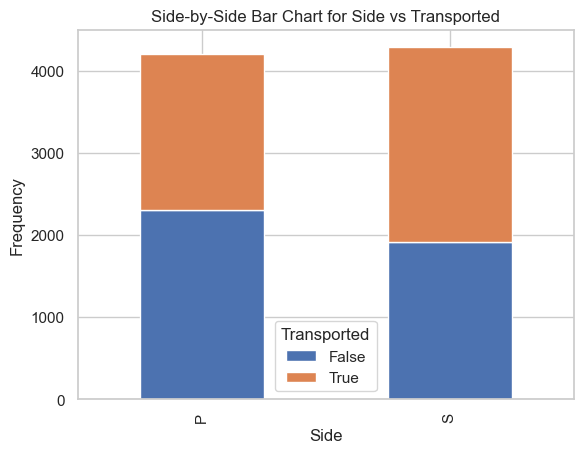

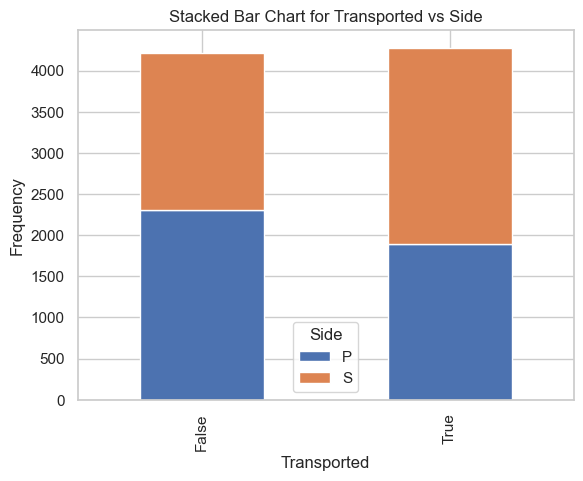

In [227]:
cat_cat_analysis(df, "Side", "Transported")

# Modeling

In [228]:
X = df.drop("Transported", axis=1)
y = df["Transported"]

In [229]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True, stratify=y
)

In [230]:
num_cols = X_train.select_dtypes(include="number").columns.tolist()
cat_cols = X_train.select_dtypes(exclude="number").columns.tolist()
print(num_cols)
print(cat_cols)

['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'familySize']
['HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'Deck', 'Num', 'Side']


In [231]:
unique_values = X_train[cat_cols].nunique()
print("Unique values for categorical columns:\n", unique_values)

Unique values for categorical columns:
 HomePlanet        3
CryoSleep         2
Destination       3
VIP               2
Deck              8
Num            1745
Side              2
dtype: int64


In [232]:
low_cardinality_cols = [col for col in cat_cols if X_train[col].nunique() <= 10]
high_cardinality_cols = list(set(cat_cols) - set(low_cardinality_cols))
print(low_cardinality_cols)
print(high_cardinality_cols)

['HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'Deck', 'Side']
['Num']


In [233]:
numerical_transformer = SimpleImputer(strategy="mean")

In [234]:
low_cardinality_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore", drop="first")),
    ]
)

In [235]:
high_cardinality_transformer = SimpleImputer(strategy="most_frequent")

In [236]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numerical_transformer, num_cols),
        ("low_card_cat", low_cardinality_transformer, low_cardinality_cols),
        ("high_card_cat", high_cardinality_transformer, high_cardinality_cols),
    ]
)

In [237]:
classifiers = [
    ("Logistic Regression", LogisticRegression(random_state=42, max_iter=1000)),
    ("Decision Tree", DecisionTreeClassifier(random_state=42)),
    ("Random Forest", RandomForestClassifier(random_state=42)),
    ("KNN", KNeighborsClassifier()),
]

Classification Report for Logistic Regression:

Training set:
               precision    recall  f1-score   support

       False       0.80      0.78      0.79      3452
        True       0.79      0.81      0.80      3502

    accuracy                           0.79      6954
   macro avg       0.79      0.79      0.79      6954
weighted avg       0.79      0.79      0.79      6954

Test set:
               precision    recall  f1-score   support

       False       0.79      0.78      0.78       863
        True       0.79      0.79      0.79       876

    accuracy                           0.79      1739
   macro avg       0.79      0.79      0.79      1739
weighted avg       0.79      0.79      0.79      1739



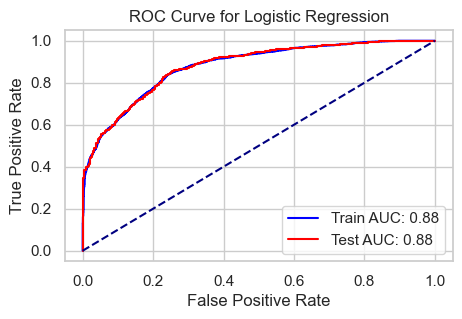



Classification Report for Decision Tree:

Training set:
               precision    recall  f1-score   support

       False       1.00      1.00      1.00      3452
        True       1.00      1.00      1.00      3502

    accuracy                           1.00      6954
   macro avg       1.00      1.00      1.00      6954
weighted avg       1.00      1.00      1.00      6954

Test set:
               precision    recall  f1-score   support

       False       0.74      0.75      0.74       863
        True       0.75      0.74      0.74       876

    accuracy                           0.74      1739
   macro avg       0.74      0.74      0.74      1739
weighted avg       0.74      0.74      0.74      1739



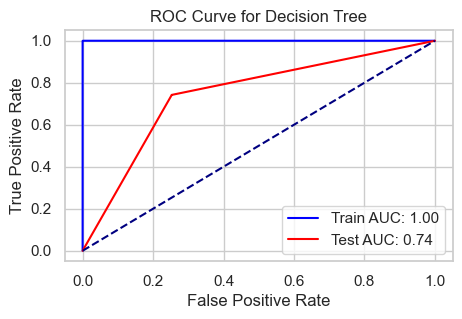



Classification Report for Random Forest:

Training set:
               precision    recall  f1-score   support

       False       1.00      1.00      1.00      3452
        True       1.00      1.00      1.00      3502

    accuracy                           1.00      6954
   macro avg       1.00      1.00      1.00      6954
weighted avg       1.00      1.00      1.00      6954

Test set:
               precision    recall  f1-score   support

       False       0.79      0.85      0.82       863
        True       0.84      0.77      0.80       876

    accuracy                           0.81      1739
   macro avg       0.81      0.81      0.81      1739
weighted avg       0.81      0.81      0.81      1739



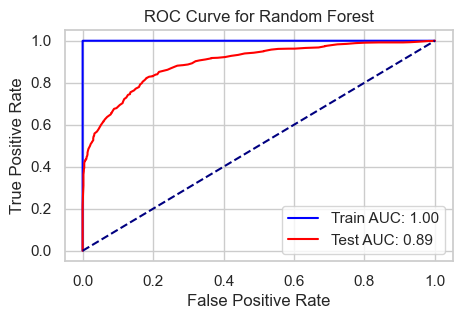



Classification Report for KNN:

Training set:
               precision    recall  f1-score   support

       False       0.84      0.79      0.81      3452
        True       0.80      0.85      0.83      3502

    accuracy                           0.82      6954
   macro avg       0.82      0.82      0.82      6954
weighted avg       0.82      0.82      0.82      6954

Test set:
               precision    recall  f1-score   support

       False       0.78      0.75      0.77       863
        True       0.76      0.80      0.78       876

    accuracy                           0.77      1739
   macro avg       0.77      0.77      0.77      1739
weighted avg       0.77      0.77      0.77      1739



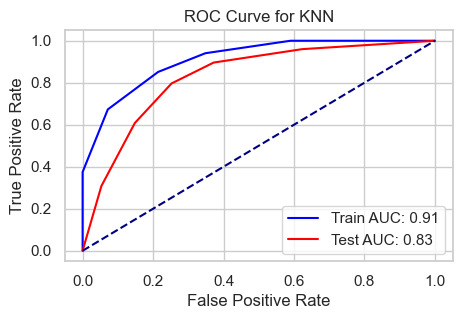

In [238]:
for name, classifier in classifiers:
    pipeline = Pipeline(
        steps=[("preprocessor", preprocessor), ("classifier", classifier)]
    )

    pipeline.fit(X_train, y_train)

    train_preds = pipeline.predict(X_train)
    test_preds = pipeline.predict(X_test)

    train_report = classification_report(y_train, train_preds)
    test_report = classification_report(y_test, test_preds)

    print(f"Classification Report for {name}:\n")
    print("Training set:\n", train_report)
    print("Test set:\n", test_report)

    train_probs = pipeline.predict_proba(X_train)[:, 1]
    test_probs = pipeline.predict_proba(X_test)[:, 1]
    fpr_train, tpr_train, _ = roc_curve(y_train, train_probs)
    fpr_test, tpr_test, _ = roc_curve(y_test, test_probs)
    auc_train = auc(fpr_train, tpr_train)
    auc_test = auc(fpr_test, tpr_test)

    plt.figure(figsize=(5, 3))
    plt.plot(fpr_train, tpr_train, color="blue", label=f"Train AUC: {auc_train:.2f}")
    plt.plot(fpr_test, tpr_test, color="red", label=f"Test AUC: {auc_test:.2f}")
    plt.plot([0, 1], [0, 1], color="navy", linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve for {name}")
    plt.legend(loc="lower right")
    plt.show()

    print("\n" + "=" * 50 + "\n")

# Tuning model

In [67]:
knn_pipeline = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", KNeighborsClassifier())]
)

param_grid = {
    "classifier__n_neighbors": [1, 2, 3, 4, 5],
    "classifier__weights": ["uniform", "distance"],
    "classifier__metric": ["euclidean", "manhattan", "minkowski"],
}

grid_search = GridSearchCV(knn_pipeline, param_grid, cv=5)

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_score = grid_search.best_score_

best_params, best_score

({'classifier__metric': 'manhattan',
  'classifier__n_neighbors': 5,
  'classifier__weights': 'uniform'},
 0.7663220394209435)

In [68]:
knn_pipeline = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", KNeighborsClassifier())]
)

param_grid = {
    "classifier__n_neighbors": [5, 6, 7, 8, 9],
    "classifier__weights": ["uniform"],
    "classifier__metric": ["manhattan"],
}

grid_search = GridSearchCV(knn_pipeline, param_grid, cv=5)

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_score = grid_search.best_score_

best_params, best_score

({'classifier__metric': 'manhattan',
  'classifier__n_neighbors': 9,
  'classifier__weights': 'uniform'},
 0.7725053659444838)

In [70]:
rf_pipeline = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("classifier", RandomForestClassifier(random_state=42)),
    ]
)

param_grid = {
    "classifier__n_estimators": [10, 50, 100, 200],
    "classifier__max_depth": [None, 10, 20, 30],
    "classifier__min_samples_split": [2, 5, 10],
    "classifier__min_samples_leaf": [1, 2, 4],
}

grid_search = GridSearchCV(rf_pipeline, param_grid, cv=5, verbose=2, n_jobs=-1)

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_score = grid_search.best_score_
n_fits = grid_search.n_splits_ * len(grid_search.cv_results_["params"])

print("Best parameters:", best_params)
print("Best cross-validation score:", best_score)
print("Number of fits:", n_fits)

Fitting 5 folds for each of 144 candidates, totalling 720 fits
[CV] END classifier__max_depth=None, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=10; total time=   0.3s
[CV] END classifier__max_depth=None, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=10; total time=   0.2s
[CV] END classifier__max_depth=None, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=10; total time=   0.2s
[CV] END classifier__max_depth=None, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=10; total time=   0.2s
[CV] END classifier__max_depth=None, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=10; total time=   0.2s
[CV] END classifier__max_depth=None, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=50; total time=   0.8s
[CV] END classifier__max_depth=None, 

In [71]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

rf_pipeline = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("classifier", RandomForestClassifier(random_state=42)),
    ]
)

param_dist = {
    "classifier__n_estimators": randint(190, 250),
    "classifier__max_depth": [None] + list(randint(10, 50).rvs(10)),
    "classifier__min_samples_split": randint(1, 5),
    "classifier__min_samples_leaf": randint(1, 5),
}

random_search = RandomizedSearchCV(
    rf_pipeline,
    param_distributions=param_dist,
    n_iter=100,
    cv=5,
    verbose=2,
    random_state=42,
)

random_search.fit(X_train, y_train)

best_params = random_search.best_params_
best_score = random_search.best_score_
n_fits = random_search.n_splits_ * random_search.n_iter

print("Best parameters:", best_params)
print("Best cross-validation score:", best_score)
print("Number of fits:", n_fits)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] END classifier__max_depth=48, classifier__min_samples_leaf=4, classifier__min_samples_split=1, classifier__n_estimators=204; total time=   0.0s
[CV] END classifier__max_depth=48, classifier__min_samples_leaf=4, classifier__min_samples_split=1, classifier__n_estimators=204; total time=   0.0s
[CV] END classifier__max_depth=48, classifier__min_samples_leaf=4, classifier__min_samples_split=1, classifier__n_estimators=204; total time=   0.0s
[CV] END classifier__max_depth=48, classifier__min_samples_leaf=4, classifier__min_samples_split=1, classifier__n_estimators=204; total time=   0.0s
[CV] END classifier__max_depth=48, classifier__min_samples_leaf=4, classifier__min_samples_split=1, classifier__n_estimators=204; total time=   0.0s
[CV] END classifier__max_depth=20, classifier__min_samples_leaf=4, classifier__min_samples_split=1, classifier__n_estimators=210; total time=   0.0s
[CV] END classifier__max_depth=20, classifi

/Users/fulin/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
145 fits failed out of a total of 500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
145 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/fulin/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/fulin/anaconda3/lib/python3.11/site-packages/sklearn/base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/fulin/anaconda3/lib/python3.11/site-packages/sklearn/pipeline.py", line 42

Best parameters: {'classifier__max_depth': None, 'classifier__min_samples_leaf': 3, 'classifier__min_samples_split': 3, 'classifier__n_estimators': 231}
Best cross-validation score: 0.8084566250665894
Number of fits: 500


In [189]:
rf_pipeline = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("classifier", RandomForestClassifier(random_state=42)),
    ]
)
rf_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', SimpleImputer(),
                                                  ['Age', 'RoomService',
                                                   'FoodCourt', 'ShoppingMall',
                                                   'Spa', 'VRDeck',
                                                   'familySize']),
                                                 ('low_card_cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['HomePlanet', 'CryoSleep',
                                                   'Destination', 'VIP', 'Deck',
                                                   'Side']),
                                                 ('high_card_cat',
                                                  SimpleImputer(strategy='most_frequent'),
                                                  ['Num'])])),
                ('classifier', RandomForestClassifier(random_state=42))])

In [239]:
for name, clf in classifiers:
    if name == "Logistic Regression":
        pipeline = Pipeline([("preprocessor", preprocessor), ("classifier", clf)])
        pipeline.fit(X_train, y_train)
        lr_clf = pipeline.named_steps["classifier"]
        feature_names = pipeline.named_steps["preprocessor"].get_feature_names_out()
        coef_data = pd.DataFrame(
            {"Feature": feature_names, "Coefficient": lr_clf.coef_.flatten()}
        )
        intercept_data = pd.DataFrame(
            {"Feature": ["Intercept"], "Coefficient": [lr_clf.intercept_[0]]}
        )

        result = pd.concat([intercept_data, coef_data], ignore_index=True)
        sorted_result = result.sort_values(
            by="Coefficient", ascending=False
        ).reset_index(drop=True)
        display(sorted_result)

        coef_data = pd.DataFrame(
            {
                "Feature": feature_names,
                "Coefficient": lr_clf.coef_.flatten(),
                "Abs_Coefficient": abs(lr_clf.coef_.flatten()),
            }
        )

        intercept_data = pd.DataFrame(
            {
                "Feature": ["Intercept"],
                "Coefficient": [lr_clf.intercept_[0]],
                "Abs_Coefficient": [abs(lr_clf.intercept_[0])],
            }
        )

        result = pd.concat([intercept_data, coef_data], ignore_index=True)
        sorted_result = result.sort_values(
            by="Abs_Coefficient", ascending=False
        ).reset_index(drop=True)
        display(sorted_result[["Feature", "Coefficient"]])

Feature  Coefficient
0              low_card_cat__CryoSleep_True     1.508148
1           low_card_cat__HomePlanet_Europa     1.473923
2                      low_card_cat__Deck_C     0.793434
3                      low_card_cat__Deck_B     0.603237
4                      low_card_cat__Side_S     0.512042
5             low_card_cat__HomePlanet_Mars     0.416460
6                      low_card_cat__Deck_D     0.131769
7                                 Intercept     0.080896
8                           num__familySize     0.020628
9                            num__FoodCourt     0.000506
10                        num__ShoppingMall     0.000499
11                       high_card_cat__Num     0.000323
12                         num__RoomService    -0.001452
13                              num__VRDeck    -0.001751
14                                 num__Spa    -0.001970
15                     low_card_cat__Deck_T    -0.006778
16                                 num__Age    -0.009419
17                   low_card_cat__VIP_True    -0.050041
18                     low_card_cat__Deck_F    -0.214833
19    low_card_cat__Destination_TRAPPIST-1e    -0.311490
20  low_card_cat__Destination_PSO J318.5-22    -0.400738
21                     low_card_cat__Deck_E    -0.506562
22                     low_card_cat__Deck_G    -0.626879

Feature  Coefficient
0              low_card_cat__CryoSleep_True     1.508148
1           low_card_cat__HomePlanet_Europa     1.473923
2                      low_card_cat__Deck_C     0.793434
3                      low_card_cat__Deck_G    -0.626879
4                      low_card_cat__Deck_B     0.603237
5                      low_card_cat__Side_S     0.512042
6                      low_card_cat__Deck_E    -0.506562
7             low_card_cat__HomePlanet_Mars     0.416460
8   low_card_cat__Destination_PSO J318.5-22    -0.400738
9     low_card_cat__Destination_TRAPPIST-1e    -0.311490
10                     low_card_cat__Deck_F    -0.214833
11                     low_card_cat__Deck_D     0.131769
12                                Intercept     0.080896
13                   low_card_cat__VIP_True    -0.050041
14                          num__familySize     0.020628
15                                 num__Age    -0.009419
16                     low_card_cat__Deck_T    -0.006778
17                                 num__Spa    -0.001970
18                              num__VRDeck    -0.001751
19                         num__RoomService    -0.001452
20                           num__FoodCourt     0.000506
21                        num__ShoppingMall     0.000499
22                       high_card_cat__Num     0.000323

Feature num__Age: 0.12266491966654663
Feature num__RoomService: 0.10381594994682858
Feature num__FoodCourt: 0.07946213587905851
Feature num__ShoppingMall: 0.06780207600137894
Feature num__Spa: 0.11014652263017982
Feature num__VRDeck: 0.09437532072703968
Feature num__familySize: 0.041801344847891296
Feature low_card_cat__HomePlanet_Europa: 0.021949921353480336
Feature low_card_cat__HomePlanet_Mars: 0.013837767807721444
Feature low_card_cat__CryoSleep_True: 0.08760274818198813
Feature low_card_cat__Destination_PSO J318.5-22: 0.00715026412320896
Feature low_card_cat__Destination_TRAPPIST-1e: 0.014349483141268911
Feature low_card_cat__VIP_True: 0.002453178576127563
Feature low_card_cat__Deck_B: 0.006402211945315626
Feature low_card_cat__Deck_C: 0.006168949650665815
Feature low_card_cat__Deck_D: 0.0034525246651863632
Feature low_card_cat__Deck_E: 0.010939756910257854
Feature low_card_cat__Deck_F: 0.014570660344128863
Feature low_card_cat__Deck_G: 0.014854882328175601
Feature low_card_cat__D

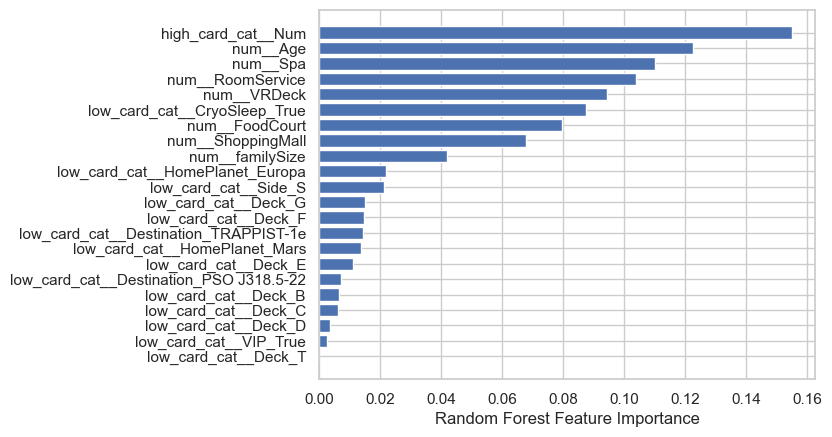

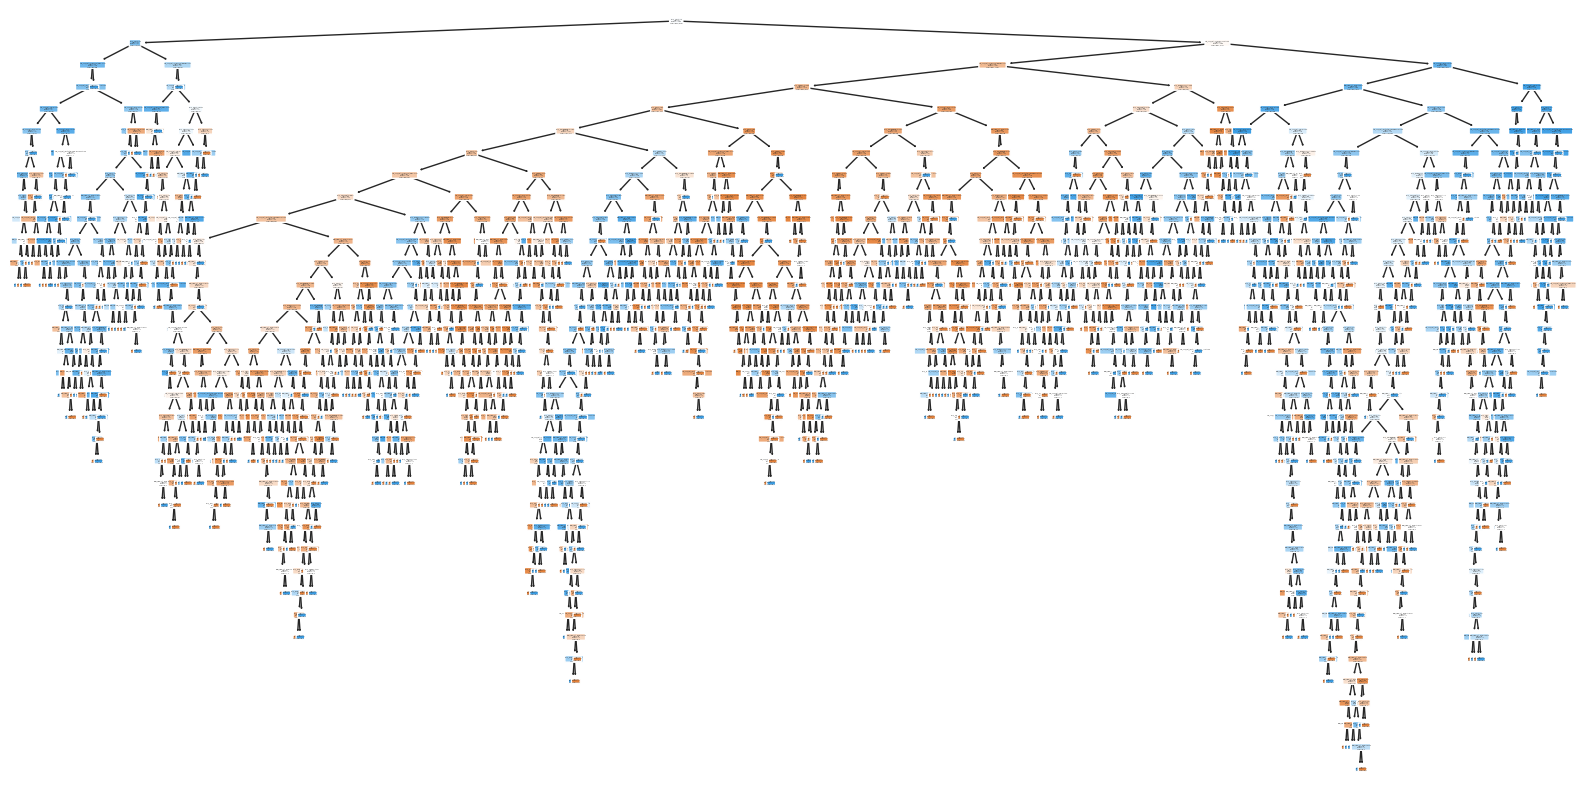

In [240]:
from sklearn.tree import plot_tree

for name, clf in classifiers:
    if name == "Random Forest":
        pipeline = Pipeline([("preprocessor", preprocessor), ("classifier", clf)])
        pipeline.fit(X_train, y_train)

        rf_clf = pipeline.named_steps["classifier"]

        importances = rf_clf.feature_importances_

        feature_names = pipeline.named_steps["preprocessor"].get_feature_names_out()

        for feature, importance in zip(feature_names, importances):
            print(f"Feature {feature}: {importance}")

        sorted_idx = importances.argsort()
        plt.barh(feature_names[sorted_idx], importances[sorted_idx])
        plt.xlabel("Random Forest Feature Importance")
        plt.show()

        feature_names_list = feature_names.tolist()

        # Draw a branching diagram of a decision tree (only one is drawn as an example)
        plt.figure(figsize=(20, 10))
        plot_tree(
            rf_clf.estimators_[10],
            filled=True,
            feature_names=feature_names_list,
            rounded=True,
        )
        plt.show()

### PCA

We want to use some more deligient models such as SVM, which take a long time to run. THerefore, we are intrested in dimensional reduction. Our previous run of SVM took 2 hours, so we are hoping we can reduce the data to shorten that time.

In [117]:
# if fanalysis is already installed, import it - else install and import it
try:
    from fanalysis.pca import PCA
except:
    !pip install fanalysis
    from fanalysis.pca import PCA

In [241]:
df_transformed = preprocessor.fit_transform(X)

In [242]:
feature_names = (
    preprocessor.named_transformers_["num"].get_feature_names_out(num_cols).tolist()
    + preprocessor.named_transformers_["low_card_cat"]
    .get_feature_names_out(low_cardinality_cols)
    .tolist()
    + preprocessor.named_transformers_["high_card_cat"]
    .get_feature_names_out(high_cardinality_cols)
    .tolist()
)

In [243]:
df_transformed = pd.DataFrame(df_transformed, columns=feature_names)

In [244]:
df_transformed

Age RoomService FoodCourt ShoppingMall     Spa  VRDeck familySize  \
0     39.0         0.0       0.0          0.0     0.0     0.0        1.0   
1     24.0       109.0       9.0         25.0   549.0    44.0        1.0   
2     58.0        43.0    3576.0          0.0  6715.0    49.0        2.0   
3     33.0         0.0    1283.0        371.0  3329.0   193.0        2.0   
4     16.0       303.0      70.0        151.0   565.0     2.0        1.0   
...    ...         ...       ...          ...     ...     ...        ...   
8688  41.0         0.0    6819.0          0.0  1643.0    74.0        1.0   
8689  18.0         0.0       0.0          0.0     0.0     0.0        1.0   
8690  26.0         0.0       0.0       1872.0     1.0     0.0        1.0   
8691  32.0         0.0    1049.0          0.0   353.0  3235.0        2.0   
8692  44.0       126.0    4688.0          0.0     0.0    12.0        2.0   

     HomePlanet_Europa HomePlanet_Mars CryoSleep_True  ... VIP_True Deck_B  \
0                  1.0             0.0            0.0  ...      0.0    1.0   
1                  0.0             0.0            0.0  ...      0.0    0.0   
2                  1.0             0.0            0.0  ...      1.0    0.0   
3                  1.0             0.0            0.0  ...      0.0    0.0   
4                  0.0             0.0            0.0  ...      0.0    0.0   
...                ...             ...            ...  ...      ...    ...   
8688               1.0             0.0            0.0  ...      1.0    0.0   
8689               0.0             0.0            1.0  ...      0.0    0.0   
8690               0.0             0.0            0.0  ...      0.0    0.0   
8691               1.0             0.0            0.0  ...      0.0    0.0   
8692               1.0             0.0            0.0  ...      0.0    0.0   

     Deck_C Deck_D Deck_E Deck_F Deck_G Deck_T Side_S   Num  
0       0.0    0.0    0.0    0.0    0.0    0.0    0.0     0  
1       0.0    0.0    0.0    1.0    0.0    0.0    1.0     0  
2       0.0    0.0    0.0    0.0    0.0    0.0    1.0     0  
3       0.0    0.0    0.0    0.0    0.0    0.0    1.0     0  
4       0.0    0.0    0.0    1.0    0.0    0.0    1.0     1  
...     ...    ...    ...    ...    ...    ...    ...   ...  
8688    0.0    0.0    0.0    0.0    0.0    0.0    0.0    98  
8689    0.0    0.0    0.0    0.0    1.0    0.0    1.0  1499  
8690    0.0    0.0    0.0    0.0    1.0    0.0    1.0  1500  
8691    0.0    0.0    1.0    0.0    0.0    0.0    1.0   608  
8692    0.0    0.0    1.0    0.0    0.0    0.0    1.0   608  

[8693 rows x 22 columns]

In [245]:
# Our dataframe needs to not have str values - Num column is an object
df_transformed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 22 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Age                        8693 non-null   object
 1   RoomService                8693 non-null   object
 2   FoodCourt                  8693 non-null   object
 3   ShoppingMall               8693 non-null   object
 4   Spa                        8693 non-null   object
 5   VRDeck                     8693 non-null   object
 6   familySize                 8693 non-null   object
 7   HomePlanet_Europa          8693 non-null   object
 8   HomePlanet_Mars            8693 non-null   object
 9   CryoSleep_True             8693 non-null   object
 10  Destination_PSO J318.5-22  8693 non-null   object
 11  Destination_TRAPPIST-1e    8693 non-null   object
 12  VIP_True                   8693 non-null   object
 13  Deck_B                     8693 non-null   object
 14  Deck_C  

In [246]:
df_transformed = df_transformed.astype("float64")
df_transformed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 22 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Age                        8693 non-null   float64
 1   RoomService                8693 non-null   float64
 2   FoodCourt                  8693 non-null   float64
 3   ShoppingMall               8693 non-null   float64
 4   Spa                        8693 non-null   float64
 5   VRDeck                     8693 non-null   float64
 6   familySize                 8693 non-null   float64
 7   HomePlanet_Europa          8693 non-null   float64
 8   HomePlanet_Mars            8693 non-null   float64
 9   CryoSleep_True             8693 non-null   float64
 10  Destination_PSO J318.5-22  8693 non-null   float64
 11  Destination_TRAPPIST-1e    8693 non-null   float64
 12  VIP_True                   8693 non-null   float64
 13  Deck_B                     8693 non-null   float

In [247]:
# instantiate acp object from PCA class
acp = PCA(
    std_unit=True, row_labels=df_transformed.index, col_labels=df_transformed.columns
)

D = df_transformed.values
p = df_transformed.shape[1]

# run PCA on X observed data
acp.fit(D)

PCA(col_labels=Index(['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'familySize', 'HomePlanet_Europa', 'HomePlanet_Mars', 'CryoSleep_True',
       'Destination_PSO J318.5-22', 'Destination_TRAPPIST-1e', 'VIP_True',
       'Deck_B', 'Deck_C', 'Deck_D', 'Deck_E', 'Deck_F', 'Deck_G', 'Deck_T',
       'Side_S', 'Num'],
      dtype='object'),
    row_labels=RangeIndex(start=0, stop=8693, step=1))

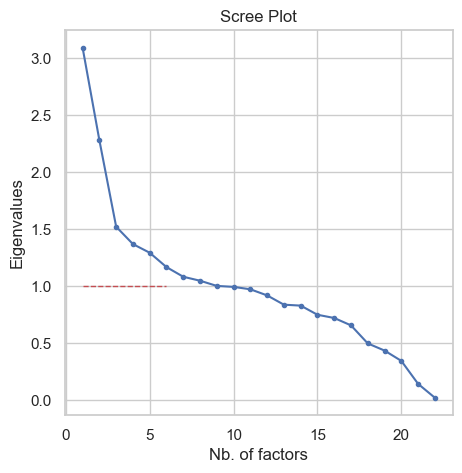

In [248]:
# print scree plot

# first the main plot
fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(range(1, p + 1), acp.eig_[0], ".-")
ax.set_xlabel("Nb. of factors")
ax.set_ylabel("Eigenvalues")
plt.title("Scree Plot")

# add Kaiser's threshold line
ax.plot([1, 6], [1, 1], "r--", linewidth=1)

plt.show()

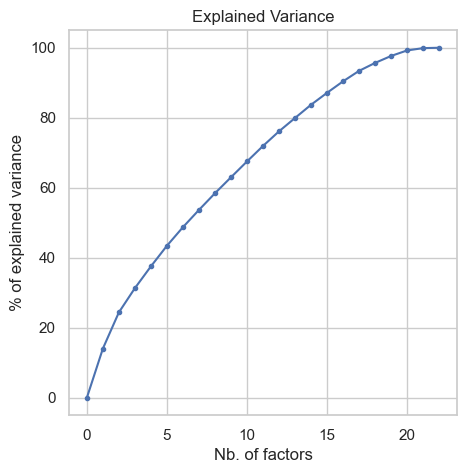

In [249]:
# print explained variance plot

fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(range(0, p + 1), np.append(0, acp.eig_[2]), ".-")
ax.set_xlabel("Nb. of factors")
ax.set_ylabel("% of explained variance")
plt.title("Explained Variance")

plt.show()

We can see from the variance explained that there is no obvious elbow. Each variable is significant in explaining the data. The Scree plot shows that line passes Kaiser's threshold around 10 components. We will explore further with a simialr method of PCA.

In [250]:
## Check how many compenents are need for 95% of variance explained

abc = PCA(n_components=0.95)
abc.fit(D)
abc.n_components_

17

We need 18 out of 28 componenets to explaion 95% of variance. Seems quite useless in the scope of making model analysis more efficent.

## Clustring

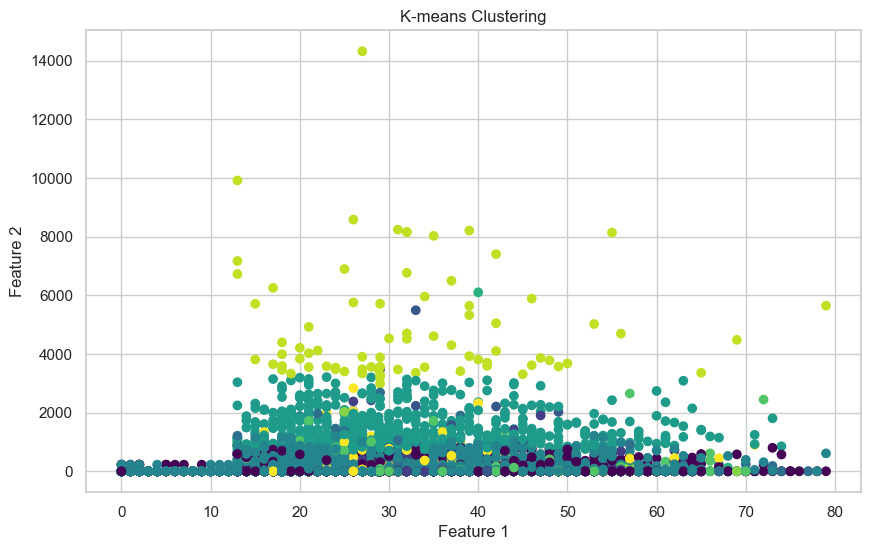

In [186]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# scaler = StandardScaler()
# df_scaled = scaler.fit_transform(df_transformed)
df_scaled = df_transformed

kmeans = KMeans(
    n_clusters=12,
    random_state=42,
    init="k-means++",
    n_init=10,
    max_iter=300,
    tol=0.0001,
)
clusters = kmeans.fit_predict(df_scaled)

predictors["Cluster"] = clusters

plt.figure(figsize=(10, 6))
plt.scatter(
    predictors.iloc[:, 0],
    predictors.iloc[:, 1],
    c=predictors["Cluster"],
    cmap="viridis",
)
plt.title("K-means Clustering")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()

In [172]:
df_result = pd.DataFrame(df_scaled, columns=df_transformed.columns)

In [176]:
df_result["Cluster"] = pd.DataFrame(clusters)
df_result

Age  RoomService  FoodCourt  ShoppingMall       Spa    VRDeck  \
0     0.709437    -0.340590  -0.287314     -0.290817 -0.276663 -0.269023   
1    -0.336717    -0.175364  -0.281669     -0.248968  0.211505 -0.230194   
2     2.034566    -0.275409   1.955616     -0.290817  5.694289 -0.225782   
3     0.290975    -0.340590   0.517406      0.330225  2.683471 -0.098708   
4    -0.894666     0.118709  -0.243409     -0.038048  0.225732 -0.267258   
...        ...          ...        ...           ...       ...       ...   
8688  0.848924    -0.340590   3.989682     -0.290817  1.184286 -0.203720   
8689 -0.755179    -0.340590  -0.287314     -0.290817 -0.276663 -0.269023   
8690 -0.197230    -0.340590  -0.287314      2.842851 -0.275774 -0.269023   
8691  0.221232    -0.340590   0.370637     -0.290817  0.037223  2.585740   
8692  1.058155    -0.149594   2.653082     -0.290817 -0.276663 -0.258433   

      familySize  HomePlanet_Earth  HomePlanet_Europa  HomePlanet_Mars  ...  \
0      -0.648735         -1.111173           1.754795        -0.503664  ...   
1      -0.648735          0.899950          -0.569867        -0.503664  ...   
2      -0.022268         -1.111173           1.754795        -0.503664  ...   
3      -0.022268         -1.111173           1.754795        -0.503664  ...   
4      -0.648735          0.899950          -0.569867        -0.503664  ...   
...          ...               ...                ...              ...  ...   
8688   -0.648735         -1.111173           1.754795        -0.503664  ...   
8689   -0.648735          0.899950          -0.569867        -0.503664  ...   
8690   -0.648735          0.899950          -0.569867        -0.503664  ...   
8691   -0.022268         -1.111173           1.754795        -0.503664  ...   
8692   -0.022268         -1.111173           1.754795        -0.503664  ...   

       Deck_C    Deck_D    Deck_E    Deck_F    Deck_G   Deck_T    Side_P  \
0    -0.30661 -0.241218 -0.334759 -0.724629 -0.645897 -0.02399  1.032865   
1    -0.30661 -0.241218 -0.334759  1.380016 -0.645897 -0.02399 -0.968181   
2    -0.30661 -0.241218 -0.334759 -0.724629 -0.645897 -0.02399 -0.968181   
3    -0.30661 -0.241218 -0.334759 -0.724629 -0.645897 -0.02399 -0.968181   
4    -0.30661 -0.241218 -0.334759  1.380016 -0.645897 -0.02399 -0.968181   
...       ...       ...       ...       ...       ...      ...       ...   
8688 -0.30661 -0.241218 -0.334759 -0.724629 -0.645897 -0.02399  1.032865   
8689 -0.30661 -0.241218 -0.334759 -0.724629  1.548235 -0.02399 -0.968181   
8690 -0.30661 -0.241218 -0.334759 -0.724629  1.548235 -0.02399 -0.968181   
8691 -0.30661 -0.241218  2.987225 -0.724629 -0.645897 -0.02399 -0.968181   
8692 -0.30661 -0.241218  2.987225 -0.724629 -0.645897 -0.02399 -0.968181   

        Side_S       Num  Cluster  
0    -1.032865 -1.149753        4  
1     0.968181 -1.149753        3  
2     0.968181 -1.149753        7  
3     0.968181 -1.149753        6  
4     0.968181 -1.147800        3  
...        ...       ...      ...  
8688 -1.032865 -0.958291        7  
8689  0.968181  1.778839       10  
8690  0.968181  1.780793        1  
8691  0.968181  0.038095       11  
8692  0.968181  0.038095       11  

[8693 rows x 29 columns]

In [177]:
df_result.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 29 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Age                        8693 non-null   float64
 1   RoomService                8693 non-null   float64
 2   FoodCourt                  8693 non-null   float64
 3   ShoppingMall               8693 non-null   float64
 4   Spa                        8693 non-null   float64
 5   VRDeck                     8693 non-null   float64
 6   familySize                 8693 non-null   float64
 7   HomePlanet_Earth           8693 non-null   float64
 8   HomePlanet_Europa          8693 non-null   float64
 9   HomePlanet_Mars            8693 non-null   float64
 10  CryoSleep_False            8693 non-null   float64
 11  CryoSleep_True             8693 non-null   float64
 12  Destination_55 Cancri e    8693 non-null   float64
 13  Destination_PSO J318.5-22  8693 non-null   float

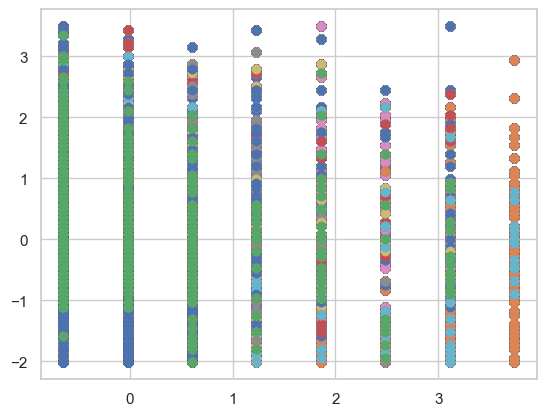

In [185]:
for x in df_result["Cluster"]:
    plt.scatter(
        x=df_result.loc[df_result["Cluster"] == x, "familySize"],
        y=df_result.loc[df_result["Cluster"] == x, "Age"],
    )

Text(0, 0.5, 'CryoSleep_True')

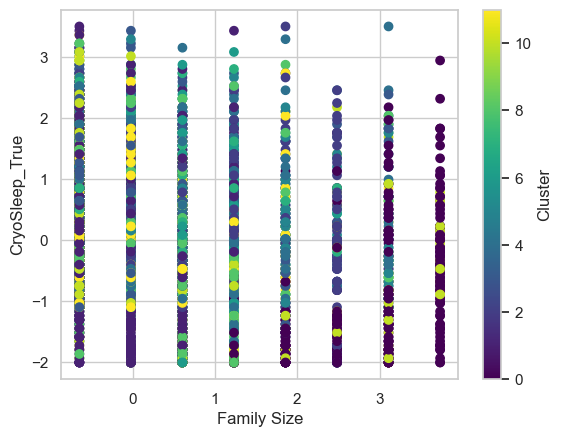

In [184]:
scatter = plt.scatter(
    df_result["familySize"],
    # df_result["CryoSleep_True"],
    df_result["Age"],
    c=df_result["Cluster"],
    cmap="viridis",
)
plt.colorbar(scatter, label="Cluster")
plt.xlabel("Family Size")
plt.ylabel("CryoSleep_True")

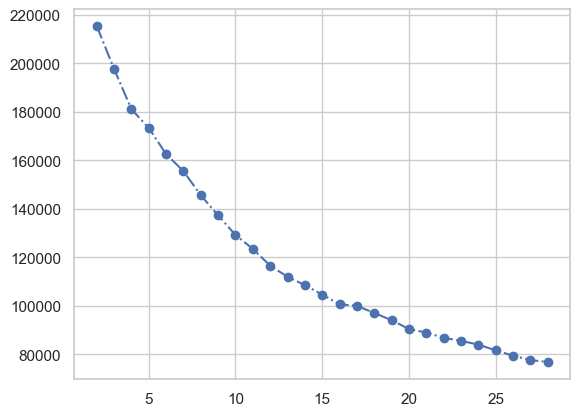

In [165]:
distortions = []
for k in range(2, 29):
    km2 = KMeans(
        n_clusters=k,
        random_state=42,
        init="k-means++",
        n_init=10,
        max_iter=300,
        tol=0.0001,
    )
    km2.fit(df_scaled)
    distortions.append(km2.inertia_)

plt.plot(range(2, 29), distortions, marker="o", linestyle="-.")

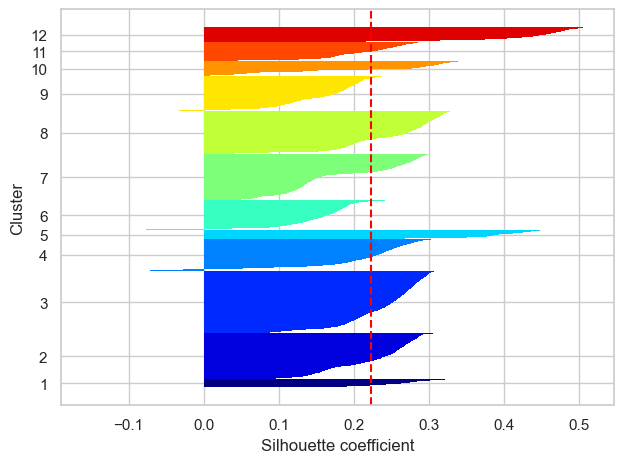

In [167]:
from sklearn.metrics import silhouette_samples

y_km = (
    KMeans(
        n_clusters=12,
        random_state=42,
        init="random",
        n_init=10,
        max_iter=300,
        tol=0.0001,
    )
    .fit(df_scaled)
    .predict(df_scaled)
)
silhouette_vals = silhouette_samples(df_scaled, y_km, metric="euclidean")

from sklearn.metrics import silhouette_score

silhouette_score(df_scaled, y_km)

import matplotlib.cm as cm

# GET THE CLUSTERS FROM THE PREDICTED VECTOR y-km

cluster_labels = np.unique(y_km)
n_clusters = cluster_labels.shape[0]

y_ax_lower, y_ax_upper = 0, 0
yticks = []

# for each cluster, get the silhouette values and sort them
for i, c in enumerate(cluster_labels):
    c_silhouette_vals = silhouette_vals[y_km == c]
    # sort them
    c_silhouette_vals.sort()

    y_ax_upper += len(c_silhouette_vals)

    # specify the color with respect to the number of clusters
    color = cm.jet(i / n_clusters)
    plt.barh(
        range(y_ax_lower, y_ax_upper),
        c_silhouette_vals,
        height=1.0,
        edgecolor="none",
        color=color,
    )

    yticks.append((y_ax_lower + y_ax_upper) / 2)
    y_ax_lower += len(c_silhouette_vals)

# compute and plot the average silhouette
silhouette_avg = silhouette_score(df_scaled, y_km)


plt.axvline(silhouette_avg, color="red", linestyle="--")

plt.yticks(yticks, cluster_labels + 1)
plt.ylabel("Cluster")
plt.xlabel("Silhouette coefficient")

plt.tight_layout()
plt.show()